In [1]:
# GPU 사용확인
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15616340759142144696
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7243933952
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6303112075148382388
physical_device_desc: "device: 0, name: GeForce RTX 2080, pci bus id: 0000:17:00.0, compute capability: 7.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 6462304416
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17174152239813122194
physical_device_desc: "device: 1, name: GeForce RTX 2080, pci bus id: 0000:b3:00.0, compute capability: 7.5"
]


# cifar100 데이터셋 학습 (to do)

CIFAR-100 데이터셋은 총 100개의 label로 이루어진 이미지 분류를 위한 데이터셋이다.

`각각의 레이블마다 32×32 크기 이미지인 50,000개의 training 데이터셋, 10,000개의 test 데이터셋이 존재하고, 결과적으로 총 60,000개의 32×32 크기의 이미지로 데이터셋이 구성되어 있다.

## (1) 데이터셋 준비

In [1]:
import keras
import keras.backend as K

from keras.utils import np_utils
from keras import datasets
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD
from keras.layers import Input, Dense, Activation
from keras.layers import Flatten, BatchNormalization, Dropout, ReLU, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical


import albumentations as albu
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
(X, y), (X_test, y_test) = datasets.cifar100.load_data()
print(X.shape, y.shape)

(50000, 32, 32, 3) (50000, 1)


label :  [19]


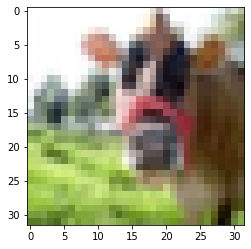

In [3]:
print('label : ',y[0])
plt.imshow(X[0])

In [4]:
# Spliting the training data into a training data and a validation data.
st = StratifiedShuffleSplit(n_splits = 2, test_size = 0.2, random_state = 1)
for train_index, val_index in st.split(X, y):
    X_train, X_val, y_train, y_val = X[train_index], X[val_index], y[train_index], y[val_index]
    
print("The number of training data : ", X_train.shape[0])
print("The number of validation data : ", X_val.shape[0])

The number of training data :  40000
The number of validation data :  10000


## (2) 모델링

In [5]:
# parameters for data
height = 224
width = 224
channels = 3
input_shape = (height, width, channels)
n_classes = 100

# parameters for optimizers
lr = 1e-3

# Parameters for training
epochs = 50
batch_size = 8

# parameters for callback functions
es_patience = 10
rlrop_patience = 5
decay_rate = 0.5

In [6]:
def np_resize(img, shape):
    return cv2.resize(img, (shape[1], shape[0]), interpolation = cv2.INTER_CUBIC)

In [7]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for keras'
    def __init__(self, images , labels = None, mode = 'fit', batch_size = batch_size,
                 dim = (height, width), channels = channels, n_classes = n_classes,
                 shuffle = True, augment = False):
        self.images = images
        self.labels = labels
        self.mode = mode
        self.batch_size = batch_size
        self.dim = dim
        self.channels = channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment
        
        self.on_epoch_end()
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.images.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.images) / self.batch_size))
        
    def __getitem__(self, index):
        'Generate one batch of data'
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # =========================================================== #
        # Generate mini-batch of X
        # =========================================================== #
        X = np.empty((self.batch_size, *self.dim, self.channels))
        for i, ID in enumerate(batch_indexes):
            # Generate a preprocessed image
            img = self.images[ID]
            img = img.astype(np.float32) / 255.
            img = np_resize(img, self.dim)
            X[i] = img
            
        
        # =========================================================== #
        # Generate mini-batch of y
        # =========================================================== #
        if self.mode == 'fit':
            y = self.labels[batch_indexes]
            y = to_categorical(y, n_classes)
            '''
            y = np.zeros((self.batch_size, self.n_classes), dtype = np.uint8)
            for i, ID in enumerate(batch_indexes):
                # one hot encoded label
                y[i, self.labels[ID]] = 1
            '''
            # Augmentation should only be implemented in the training part.
            if self.augment == True:
                X = self.__augment_batch(X)                
            
            return X,y
        
        elif self.mode == 'predict':
            return X       
        
        else:
            raise AttributeError('The mode parameters should be set to "fit" or "predict"')
            
    def __random_transform(self, img):
        composition = albu.Compose([albu.HorizontalFlip(p = 0.5),
                                    albu.VerticalFlip(p = 0.5),
                                    albu.GridDistortion(p = 0.2),
                                    albu.ElasticTransform(p = 0.2)])
        
        return composition(image = img)['image']
        
    
    def __augment_batch(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i] = self.__random_transform(img_batch[i])
            
        return img_batch

In [8]:
train_generator = DataGenerator(X_train, y_train, augment = True)
valid_generator = DataGenerator(X_val, y_val, augment = False)

In [9]:
import efficientnet.keras as efn 

efnb7 = efn.EfficientNetB7(weights = 'imagenet', include_top = False, classes = n_classes, input_shape = input_shape)

model = Sequential()
model.add(efnb7)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(n_classes, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Functional) (None, 7, 7, 2560)        64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               256100    
Total params: 64,353,780
Trainable params: 64,043,060
Non-trainable params: 310,720
_________________________________________________________________


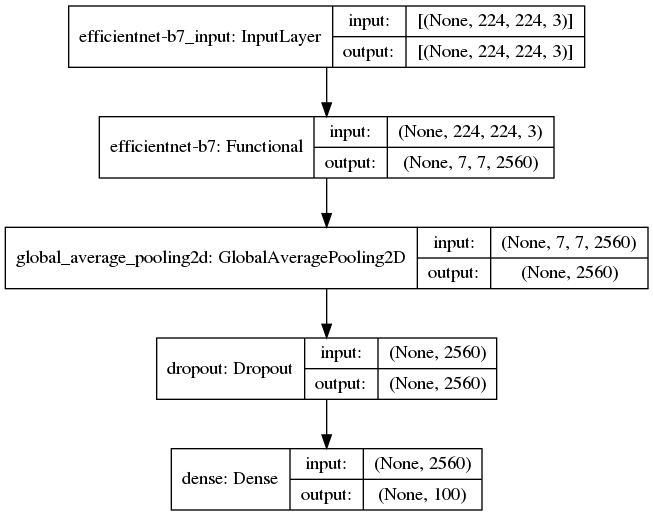

In [10]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model
%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
plot_model(model, to_file = 'mnist_model.png', show_shapes = True, show_layer_names = True)

## (3) 모델의 학습과정 설정

In [11]:
efnb7.trainable = False
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=1e-6, epsilon=None, amsgrad=False)
sgd = SGD(lr = lr, momentum = 0.9, nesterov = True)
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = es_patience, restore_best_weights = True, verbose = 1)
rlrop = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', patience = rlrop_patience, 
                        factor = decay_rate, min_lr = 1e-6, verbose = 1)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['acc'])

## (4) 모델 학습시키기

In [12]:
history = model.fit_generator(train_generator,validation_data = valid_generator, 
                           epochs = epochs, verbose = 1, callbacks = [es, rlrop])

/home/piai/anaconda3/envs/DH/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
5000/5000 [==============================] - 746s 146ms/step - loss: 3.2172 - acc: 0.2531 - val_loss: 1.8108 - val_acc: 0.5149
Epoch 2/50
5000/5000 [==============================] - 725s 145ms/step - loss: 2.4983 - acc: 0.3837 - val_loss: 1.7087 - val_acc: 0.5437
Epoch 3/50
5000/5000 [==============================] - 721s 144ms/step - loss: 2.4171 - acc: 0.4080 - val_loss: 1.6947 - val_acc: 0.5479
Epoch 4/50
5000/5000 [==============================] - 724s 145ms/step - loss: 2.3746 - acc: 0.4157 - val_loss: 1.6460 - val_acc: 0.5607
Epoch 5/50
5000/5000 [==============================] - 718s 144ms/step - loss: 2.3571 - acc: 0.4211 - val_loss: 1.6281 - val_acc: 0.5674
Epoch 6/50
5000/5000 [==============================] - 714s 143ms/step - loss: 2.3396 - acc: 0.4264 - val_loss: 1.5997 - val_acc: 0.5702
Epoch 7/50
5000/5000 [==============================] - 716s 143ms/step - loss: 2.3377 - acc: 0.4335 - val_loss: 1.5904 - val_acc: 0.5758
Epoch 8/50
5000/5000 [============

In [13]:
model.save_weights("EfficientNet2.h5")

## (5) 모델 평가하기

In [14]:
# Make sure to set shuffle be False.
test_generator = DataGenerator(X_test, mode = 'predict', augment = False, shuffle = False)
y_pred = model.predict_generator(test_generator,verbose = 1)
y_pred = np.argmax(y_pred, axis = 1)

print("The accuracy on the testing data : {:.2f}%".format(100 * accuracy_score(y_test, y_pred)))

/home/piai/anaconda3/envs/DH/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1250/1250 [==============================] - 89s 68ms/step
The accuracy on the testing data : 62.58%


## (6) 모델 사용하기

   2/1250 [..............................] - ETA: 1:28

/home/piai/anaconda3/envs/DH/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1250/1250 [==============================] - 83s 67ms/step
predict label :  [70]


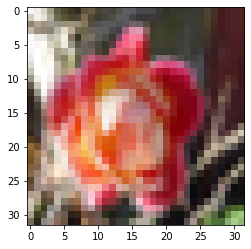

In [29]:
pred_y = model.predict_generator(test_generator,verbose = 1)
pred_y = pred_y.argmax()

print('predict label : ',y_test[-1])
plt.imshow(X_test[-1], cmap='gray')